In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

### Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. Провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
6. С отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
7. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

**Загрузка данных**

In [132]:
raw_df = pd.read_csv('rosbank_train.csv')
del raw_df['target_sum'], raw_df['channel_type']
raw_df.head()

,PERIOD,cl_id,MCC,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


**Описание колонок**

PERIOD - месяц транзакции, cl_id - id клиента, MCC - код категории продавца, channel_type - канал привлечения клиента, currency - валюта, TRDATETIME - дата/время транзакции, amount - сумма транзакции, trx_category - вид транзакции, POS – оплата через POS терминал, C2C_OUT – перевод на карту (исходящий платёж), C2C_IN – перевод на карту (входящий платёж), DEPOSIT – пополнение карты в банкомате, WD_ATM_PARTNER – снятие наличных в банкоматах партнерах, target_flag продолжит ли клиент пользоваться продуктом после льготного периода (1/0) (target), target_sum сумма транзакций вида POS за три будущих месяца (target)

**Обработка данных**

In [133]:
# Функция для ONE-HOT encoding'а
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [134]:
#Функция, которая уменьшает количество категорий, объединяя редкие в одну категорию.
def clearRare(columnname, limit = 1000):
    vc = raw_df[columnname].value_counts()
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")    
    raw_df.loc[raw_df[columnname].map(lambda x: x not in common), columnname] = 'other'
    #test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", raw_df[columnname].nunique(), "categories in raw_df")

In [135]:
#Почистим
clearRare('currency', limit = 1000)
clearRare('MCC', limit = 3000)

Set 56 currency categories to 'other'; now there are 4 categories in raw_df
Set 323 MCC categories to 'other'; now there are 22 categories in raw_df


In [136]:
#Извлечём из времени транзакции день и час в отдельные колонки
raw_df['day_of_transaction'] = raw_df['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w'))
raw_df['hour_of_transaction'] = raw_df['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H'))

In [137]:
#пробежимся one-hot'ом по некоторым колонкам
raw_df = get_one_hot(raw_df,['trx_category'])
raw_df = get_one_hot(raw_df,['currency'])
raw_df = get_one_hot(raw_df,['day_of_transaction'])
raw_df = get_one_hot(raw_df,['hour_of_transaction'])

In [138]:
#удалим колонки
del raw_df['PERIOD'],raw_df['MCC'],raw_df['currency'],raw_df['TRDATETIME'], raw_df['trx_category']

**Просуммируем количество транзакций клиентов**

In [158]:
df = raw_df.groupby('cl_id').agg('sum').reset_index()

In [159]:
df[df['target_flag']>0] = 1
del df['amount']

df = raw_df.groupby('cl_id').agg('sum'.reset_index()
#df = raw_df.groupby('cl_id').transform(pd.Series.cumsum)

aggregates = {}
    for column in df.columns:
        if df[column] != df['cl_id']:
            aggregates[column] = df[column]
        else:
            aggregates[column] = 'first'
    
df = df.groupby(['cl_d']).agg(aggregates)
df.columns = df.columns.droplevel(1)
df = df.reset_index(drop=True)


df[df['target_flag']>0] = 1
del df['amount']
df

In [160]:
#Добавим каждому клиенту mean() дневных трат по всем видам транзакций

raw1 = pd.read_csv('rosbank_train.csv')
MEAN_CASH_ADV = raw1[raw1['trx_category'] == 'CASH_ADV'].groupby('cl_id')['amount'].mean()
MEAN_CAT = raw1[raw1['trx_category'] == 'CAT'].groupby('cl_id')['amount'].mean()
MEAN_BACK_TRX = raw1[raw1['trx_category'] == 'BACK_TRX'].groupby('cl_id')['amount'].mean()
MEAN_WD_ATM_OTHER = raw1[raw1['trx_category'] == 'WD_ATM_OTHER'].groupby('cl_id')['amount'].mean()
MEAN_C2C_OUT = raw1[raw1['trx_category'] == 'C2C_OUT'].groupby('cl_id')['amount'].mean()
MEAN_WD_ATM_PARTNER = raw1[raw1['trx_category'] == 'WD_ATM_PARTNER'].groupby('cl_id')['amount'].mean()
MEAN_C2C_IN = raw1[raw1['trx_category'] == 'C2C_IN'].groupby('cl_id')['amount'].mean()
MEAN_WD_ATM_ROS = raw1[raw1['trx_category'] == 'WD_ATM_ROS'].groupby('cl_id')['amount'].mean()
MEAN_DEPOSIT = raw1[raw1['trx_category'] == 'DEPOSIT'].groupby('cl_id')['amount'].mean()
MEAN_POS = raw1[raw1['trx_category'] == 'POS'].groupby('cl_id')['amount'].mean()

df['MEAN_CASH_ADV'] = df['cl_id'].map(MEAN_CASH_ADV)
df['MEAN_CAT'] = df['cl_id'].map(MEAN_CAT)
df['MEAN_BACK_TRX'] = df['cl_id'].map(MEAN_BACK_TRX)
df['MEAN_WD_ATM_OTHER'] = df['cl_id'].map(MEAN_WD_ATM_OTHER)
df['MEAN_C2C_OUT'] = df['cl_id'].map(MEAN_C2C_OUT)
df['MEAN_WD_ATM_PARTNER'] = df['cl_id'].map(MEAN_WD_ATM_PARTNER)
df['MEAN_C2C_IN'] = df['cl_id'].map(MEAN_C2C_IN)
df['MEAN_WD_ATM_ROS'] = df['cl_id'].map(MEAN_WD_ATM_ROS)
df['MEAN_DEPOSIT'] = df['cl_id'].map(MEAN_DEPOSIT)
df['MEAN_POS'] = df['cl_id'].map(MEAN_POS)
df = df.fillna(0)

In [161]:
#Посмотрим на корреляцию
corr_matrix = df.corr()
corr_matrix["target_flag"].sort_values(ascending=False)

target_flag                    1.000000
trx_category_CASH_ADV          0.970985
hour_of_transaction_01         0.916957
hour_of_transaction_02         0.895695
hour_of_transaction_03         0.891191
hour_of_transaction_23         0.865801
MEAN_DEPOSIT                   0.784259
hour_of_transaction_04         0.753515
hour_of_transaction_22         0.692839
hour_of_transaction_05         0.666118
MEAN_WD_ATM_ROS                0.607196
trx_category_CAT               0.579263
hour_of_transaction_21         0.533128
hour_of_transaction_06         0.525608
hour_of_transaction_20         0.407795
hour_of_transaction_07         0.382154
trx_category_BACK_TRX          0.302135
trx_category_WD_ATM_OTHER      0.280044
hour_of_transaction_19         0.257342
hour_of_transaction_08         0.253695
hour_of_transaction_09         0.169732
hour_of_transaction_17         0.167201
hour_of_transaction_18         0.158959
hour_of_transaction_16         0.134592
hour_of_transaction_14         0.126055


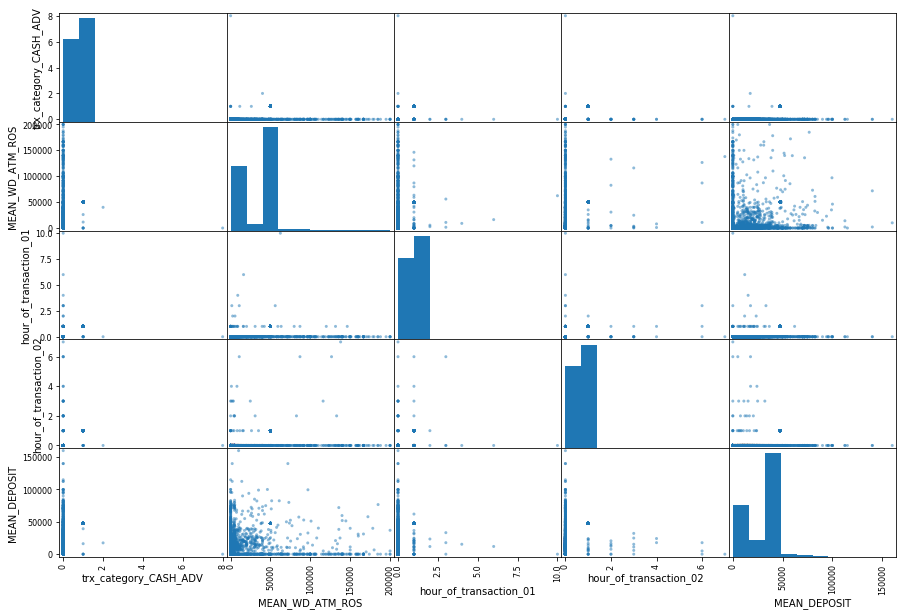

In [173]:
from pandas.plotting import scatter_matrix

attributes = ["trx_category_CASH_ADV", "MEAN_WD_ATM_ROS", "hour_of_transaction_01", "hour_of_transaction_02", "MEAN_DEPOSIT"]
_ = scatter_matrix(df[attributes], figsize=(15, 10))

In [162]:
y_class = df['target_flag'].values

del df['target_flag']
del df['cl_id']
#df = df.reset_index(drop = True)

In [157]:
df

,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,trx_category_WD_ATM_OTHER,trx_category_WD_ATM_PARTNER,trx_category_WD_ATM_ROS,...,MEAN_CASH_ADV,MEAN_CAT,MEAN_BACK_TRX,MEAN_WD_ATM_OTHER,MEAN_C2C_OUT,MEAN_WD_ATM_PARTNER,MEAN_C2C_IN,MEAN_WD_ATM_ROS,MEAN_DEPOSIT,MEAN_POS
0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,36562.000000,0.000000,0.000000,0.000000,20000.000000,2607.000000
1,0.0,0.0,0.0,0.0,0.0,2.0,101.0,0.0,0.0,1.0,...,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,50000.000000,47500.000000,1213.643960
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,50000.000000,47500.000000,1213.643960
3,0.0,3.0,0.0,0.0,0.0,1.0,29.0,0.0,1.0,5.0,...,0.00,0.000000,0.00,0.0,0.000000,100000.000000,98983.333333,87000.000000,5000.000000,426.382414
4,0.0,1.0,19.0,0.0,3.0,24.0,374.0,0.0,3.0,39.0,...,0.00,12564.993333,0.00,0.0,1141.731579,1800.000000,10000.000000,10828.205128,17762.500000,537.315802
5,0.0,0.0,0.0,0.0,0.0,10.0,207.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,18200.000000,1187.184251
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,50000.000000,47500.000000,1213.643960
7,0.0,0.0,0.0,0.0,0.0,3.0,74.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,71666.666667,3004.163378
8,1.0,2.0,0.0,0.0,0.0,8.0,113.0,0.0,0.0,0.0,...,0.00,0.000000,2777.00,0.0,0.000000,0.000000,2000.500000,0.000000,14000.000000,1947.819912
9,0.0,0.0,0.0,0.0,2.0,8.0,45.0,1.0,2.0,1.0,...,0.00,250.000000,0.00,3000.0,0.000000,4950.000000,0.000000,3500.000000,15325.000000,2450.377778


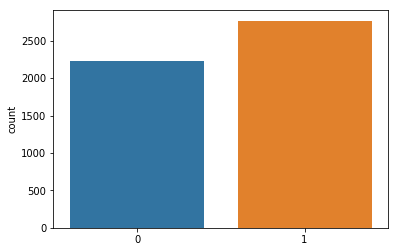

In [154]:
import seaborn as sns
ax = sns.countplot(y,label="Count")

In [179]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y_class, test_size = 0.2,stratify=y_class, random_state = 2077)

sum_negative = np.count_nonzero(y_train == 0)
sum_positive = np.count_nonzero(y_train == 1)
weights = [1, sum_negative/sum_positive]

X_train

,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,trx_category_WD_ATM_OTHER,trx_category_WD_ATM_PARTNER,trx_category_WD_ATM_ROS,...,MEAN_CASH_ADV,MEAN_CAT,MEAN_BACK_TRX,MEAN_WD_ATM_OTHER,MEAN_C2C_OUT,MEAN_WD_ATM_PARTNER,MEAN_C2C_IN,MEAN_WD_ATM_ROS,MEAN_DEPOSIT,MEAN_POS
507,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960
3876,0.0,1.0,1.0,0.0,0.0,7.0,42.0,0.0,0.0,1.0,...,0.0,0.00,0.00,0.000000,4626.000000,0.000000,15000.000,1000.000000,15285.714286,4001.584524
4388,1.0,20.0,0.0,0.0,0.0,6.0,145.0,0.0,0.0,3.0,...,0.0,0.00,8560.00,0.000000,0.000000,0.000000,19500.000,33333.333333,25833.333333,1931.591448
1325,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960
2794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960
4141,0.0,1.0,1.0,0.0,0.0,19.0,169.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.000000,500.000000,0.000000,15680.000,0.000000,9842.105263,1374.643787
4547,3.0,1.0,0.0,0.0,1.0,2.0,72.0,0.0,1.0,1.0,...,0.0,1000.00,958.05,0.000000,0.000000,6000.000000,60000.000,40000.000000,67500.000000,3596.265556
1901,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960
3973,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960
4117,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000,50000.000000,47500.000000,1213.643960


In [180]:
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score

def lasso_regression(X, Y, X_t, Y_t, alpha):
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(X, Y)
    Y_pred_tr = lassoreg.predict(X)
    Y_pred_test = lassoreg.predict(X_t)

    RAS=roc_auc_score(Y, Y_pred_tr)
    ret = [RAS]
    ret.append(roc_auc_score(Y_t, Y_pred_test))

    ret.append(lassoreg.intercept_)

    for s in range(len(lassoreg.coef_)):
        ret.append(lassoreg.coef_[s])
    return ret

In [182]:
col = ['roc_auc_train', 'roc_auc_test',\
       #'R2_tr', 'R2_test', \
       'intercept'] + list(X_train) #.columns
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,8)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

In [183]:

alpha_lasso = [1e-8,1e-7, 1e-6, 1e-5, 1e-4,1e-3, 1e-2,1e-1, 1]
for i in range(8):
    coef_matrix_lasso.iloc[i, ] = lasso_regression(X_train, y_train, X_test, y_test, alpha_lasso[i])

In [184]:
coef_matrix_lasso

,roc_auc_train,roc_auc_test,intercept,trx_category_BACK_TRX,trx_category_C2C_IN,trx_category_C2C_OUT,trx_category_CASH_ADV,trx_category_CAT,trx_category_DEPOSIT,trx_category_POS,...,MEAN_CASH_ADV,MEAN_CAT,MEAN_BACK_TRX,MEAN_WD_ATM_OTHER,MEAN_C2C_OUT,MEAN_WD_ATM_PARTNER,MEAN_C2C_IN,MEAN_WD_ATM_ROS,MEAN_DEPOSIT,MEAN_POS
alpha_1e-08,1,1,0.000628968,-0.0609926,-0.0621611,-0.0628939,-0.0226775,-0.0598535,-0.0626141,-0.0618968,...,-5.91104e-07,-8.73448e-08,-3.45618e-08,-6.17692e-08,1.62508e-08,-2.11138e-08,-4.35292e-08,4.75513e-08,1.14918e-07,-5.22195e-08
alpha_1e-07,1,1,5.71132e-05,-0.0448796,-0.0449789,-0.0450235,-0.0414361,-0.0447483,-0.0450034,-0.0449666,...,-5.1096e-08,-6.88147e-09,-2.58668e-09,-3.94334e-09,0,-1.65729e-09,-2.42539e-09,3.43899e-09,8.92676e-09,-4.15852e-09
alpha_1e-06,1,1,0.000743879,0.00071006,-0.000153598,-0.000614085,0.0337251,0.00173974,-0.000439621,-0,...,-4.88648e-07,-6.22579e-08,-2.40367e-08,-3.87186e-08,0,-1.67146e-08,-3.00491e-08,3.86948e-08,1.00754e-07,-4.78658e-08
alpha_1e-05,0.99944,1,0.00780285,0.0076006,-0.00169062,-0.00670237,0.35958,0.0185267,-0.00481154,-0,...,-5.22372e-06,-6.71072e-07,-2.59569e-07,-4.23139e-07,0,-1.7875e-07,-3.24607e-07,4.14559e-07,1.07277e-06,-5.07754e-07
alpha_0.0001,0.99832,1,0.00986487,0.00477886,-0,-0,0.53765,0.0218445,-0.000507905,-0,...,-6.0401e-06,-0,-0,-0,-0,-1.03072e-07,-5.63866e-08,3.68019e-07,1.56212e-06,-3.70134e-07
alpha_0.001,0.99776,1,0.067485,0,-0,-0,0.532526,0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,0,6.46077e-07,-0
alpha_0.01,0.5,0.5,0.5535,0,-0,0,0,0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,0,0,-0
alpha_0.1,0.5,0.5,0.5535,0,-0,0,0,0,-0,-0,...,-0,-0,-0,-0,-0,-0,-0,0,0,-0


In [ ]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

In [356]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lm = smf.ols(get_formula(_iteration_cols), df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.004993743339518926
R^2: 0.9998990992112231


In [335]:
del df['amount']

In [347]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
from xgboost import plot_tree
import seaborn as sns
from geopy.distance import vincenty

In [348]:
y = df['target_flag'].copy()

In [349]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.35, random_state=42)

In [350]:
train_columns = [col for col in df.columns.tolist()]
x_train = data_train[train_columns]
y_train = data_train['target_flag']
x_test = data_test[train_columns]
y_test = data_test['target_flag']

In [351]:
xgb = xgboost.XGBClassifier(max_depth=9, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  1.0


In [ ]:
#Обогатим средними занчениями для каждой категории транзакций

In [5]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  393170
Total transactions in test dataset:  97343


In [6]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

# aggregated_dataset = raw_df_grouped.unstack().fillna(0)
aggregated_dataset = raw_df_grouped.unstack()

In [ ]:
columns = list(raw_df.columns.values)
agg_columns = {
    'totals.transactionRevenue': ['sum'],
    'visitStartTime': ['mean'],
    'totals.hits': ['sum'],
    'totals.pageviews': ['sum']
}
aggregates = {}
for column in columns:
    if column in agg_columns:
        aggregates[column] = agg_columns[column]
    else:
        aggregates[column] = 'first'
    

test = test.groupby(['new', 'fullVisitorId']).agg(aggregates)
test.columns = test.columns.droplevel(1)
test = test.reset_index(drop=True)

In [21]:
raw_df1 = pd.read_csv('rosbank_train.csv')
a1 = (raw_df1[raw_df['target_flag'] == 1].MCC.value_counts() / raw_df1[raw_df1['target_flag'] == 0].MCC.value_counts()).sort_values(ascending = False)
a1 = a1.dropna()
a1 = a1.reset_index()
a1[''] = a1.index+1
del a1['MCC']
a1 = a1.rename(columns = {'index':'MCC','':'Rank'}).groupby('MCC')['Rank'].min()
#a1 = a1.groupby('MCC')['Rank'].min()
raw_df1['map_solvency'] = raw_df1['MCC'].map(a1)

In [25]:
raw_df.groupby(['cl_id','target_flag'])['map_solvency'].apply(lambda ser: ser.nsmallest().mean())
raw_df.groupby(['cl_id','target_flag'])['map_solvency'].apply(lambda ser: ser.nlargest(2).mean())

cl_id  target_flag
0      0              209.0
1      0              220.0
5      1              197.0
9      0              197.0
10     0              223.5
11     0              237.5
14     1              226.0
20     0              213.0
21     0              220.5
22     0              203.0
23     1              191.0
24     1              212.0
25     1              197.0
28     1              211.5
29     1              223.5
31     1              171.0
32     1              202.0
35     1              220.0
38     0              153.0
39     0              221.5
41     1              190.5
42     0              211.5
46     0              191.5
48     1              209.0
49     0              201.0
50     1              239.0
52     0              197.0
54     0              221.0
55     0              203.0
56     1              197.5
                      ...  
10162  1              206.0
10163  0              241.0
10164  1              148.5
10166  1              226.0
1